# Exploratory Data Analysis for the Delta Analytics Teaching Fellowship

**Author:** *Cynthia Thinwa*

## INTRODUCTION

### DATA HANDLING PRACTICES:

* Based on Twitter API best practice, the actual data will not be shared, only Twitter's tweet IDs for future reference
* The data will be cleaned to remove personally identifiable information like emails and phone numbers
* Exploratory Data Analysis will be described here purely for the basis of describing how the dataset was aggregated in order to be fed into the ML model

Data collection was done from a Microsoft command line running

`twint -s %23kot --since "2020-06-01 03:00:00" --until "2021-06-01 03:00:00" -o kotdata.csv --csv`

## EXPLORATORY DATA ANALYSIS

### Introduction

The raw data was loaded as follows, with the following characteristics:

1. The number of tweets:

In [1]:
import numpy as np
import pandas as pd
import os
import json

In [2]:
%load_ext rpy2.ipython

c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R

library(dplyr)
library(wordcloud)
library(RColorBrewer)
library(rtweet)
library(tidytext)
library(ggplot2)
library(wordcloud2)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: RColorBrewer



In [4]:
%%R

url <- "C:/storage/Personal drive backup/Career/Post-Masters/Delta Analytics Teaching Fellowship/EDA/2.kotdata.csv"
DATFdata <- read.delim(url)
dim(DATFdata)[1]

[1] 36305



2. The number of unique conversations had:


In [5]:
%%R

DATFdata$conversation_id <- factor(DATFdata$conversation_id)
DATFdata$id <- factor(DATFdata$id)

dim(as.data.frame(table(DATFdata$conversation_id)))[1]

[1] 35388



3. The number of unique users speaking:


In [6]:
%%R

DATFdata$user_id <- factor(DATFdata$user_id)

dim(as.data.frame(table(DATFdata$user_id)))[1]

[1] 11049



4. The most frequent language of posting:


In [7]:
%%R

lang <- as.data.frame(table(DATFdata$language))
colnames(lang) <- c('Language','Frequency')
head(lang[order(lang$Freq, decreasing = TRUE),],n=1)

  Language Frequency
8       en     27504



5. The date on which most tweets were posted (tweets were from 1st June 2020 UTC+3 upto 1st June 2021 UTC+3): 


In [8]:
%%R

dates <- as.data.frame(table(DATFdata$date))
colnames(dates) <- c('Date','Frequency')
head(dates[order(dates$Freq, decreasing = TRUE),],n=1)

          Date Frequency
262 2021-02-17       406



### Text transformation

Text cleaning was as follows, using `eng_tweets$tweet[4]` as an example:


In [9]:
%%R

# Get organic tweets first; found that all tweets were organic!

# get only English ones:
eng_tweets <- DATFdata[DATFdata$language=='en',]; print(eng_tweets$tweet[4])

# Remove funny symbols
eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'UTF-8', to = 'ISO-8859-1', sub = ''); print(eng_tweets$tweet[4])

eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'ISO-8859-1', to = 'UTF-8', sub = ''); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("https\\S*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove urls

eng_tweets$tweet <- gsub("@", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove mentions symbol

eng_tweets$tweet <- gsub("#*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove hashtags symbol

eng_tweets$tweet <- gsub("[\r\n]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove newline characters

#(we have separate columns with the details)
# Punctuation was managed as follows:
eng_tweets$tweet <- gsub("'", "", eng_tweets$tweet); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("[[:punct:]]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("amp", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) # remove ampersands

# Finally, everything was made lowercase
eng_tweets$tweet <- tolower(eng_tweets$tweet); print(eng_tweets$tweet[4])

[1]


From cffi callback <function _consolewrite_ex at 0x00000279CE476280>:
Traceback (most recent call last):
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 292: invalid continuation byte


[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] "ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to LasetoAbdaz babazubeyyr VictorWan

In [10]:
%%R

# Tokenize words
Words <- eng_tweets %>%
  select(tweet) %>%
  unnest_tokens(word, tweet)


### Word Frequency


Selecting by n


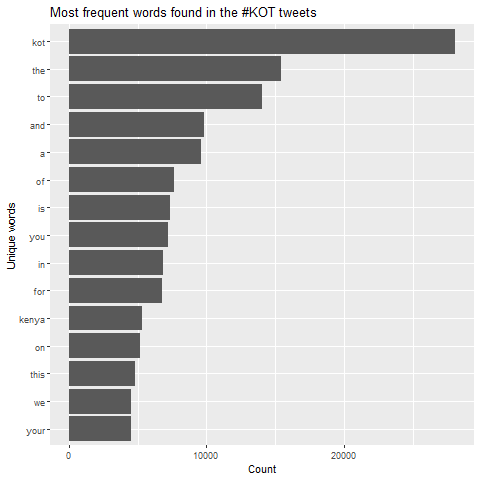

In [11]:
%%R

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets")

Joining, by = "word"
Selecting by n


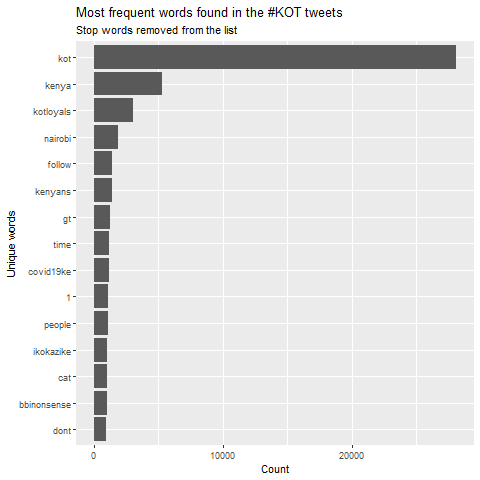

In [12]:
%%R

# remove stop words
Words <- Words %>%
  anti_join(stop_words)

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets",
       subtitle = "Stop words removed from the list")


### Hashtag Frequency

All tweets have the hashtag `#KOT`, but we are interested in what else this community talks about, so this hashtag will have to be removed from our visualization.


In [13]:
%%R

eng_tweets$hashtags <- as.character(eng_tweets$hashtags)

eng_tweets$hashtags <- gsub("[[:punct:]]", "", eng_tweets$hashtags)

# every hashtag was made lowercase
eng_tweets$hashtags <- tolower(eng_tweets$hashtags)

# and #KOT was removed before tokenization
eng_tweets$hashtags <- gsub("kot", "", eng_tweets$hashtags)

Hashtags <- eng_tweets %>%
  select(hashtags) %>%
  unnest_tokens(word, hashtags)

Hashtags_count <- as.data.frame(table(Hashtags$word))

viz1 <- wordcloud2(Hashtags_count, size=0.7)

![](viz1.PNG)

In [14]:
%%R

head(Hashtags_count[order(Hashtags_count$Freq, decreasing = TRUE),], n=10)

                  Var1 Freq
6970             kenya 3074
8039            loyals 3050
9173           nairobi 1196
2883         covid19ke 1187
6033         ikokazike 1016
1178       bbinonsense  989
2133               cat  871
4957              gato  815
8181  mainaandkingangi  756
12803      teamclassic  607


Based on the results above

* platform (`#loyals`),
* patriotism (`#kenya` and `#nairobi`),
* radio (`#mainaandkingangi` and `#teamclassic`),
* political trends (`#bbinonsense` and `#punguzamizigo`)
* job ads(`#ikokazike` and `#ikokazi`) and
* cats (`#cat` and `#gato`)

took centre stage. 


### People of Influence

In this area, we are interested in identifying people mentioned most frequently.

The text, using `eng_tweets$mentions[4]` as an example was first converted as follows:


In [15]:
%%R

eng_tweets$mentions[4]
# Remove funny symbols
eng_tweets$mentions <- iconv(eng_tweets$mentions, from = 'UTF-8', to = 'UTF-8');eng_tweets$mentions[4]

eng_tweets$mentions <- stringr::str_replace_all(
  eng_tweets$mentions, "\'", "\"")
eng_tweets$mentions <- gsub("[", "", eng_tweets$mentions, fixed = TRUE)
eng_tweets$mentions <- gsub("]", "", eng_tweets$mentions, fixed = TRUE)

df <- as.data.frame(eng_tweets$mentions); dim(df)
df[df == ""] <- NA  
df <- na.omit(df); dim(df)


[1] 6887    1


In [16]:
#get file location
os.getcwd()

'C:\\Users\\CT\\Documents\\GitHub\\Delta-Analytics-2021-CT-Project'

In [17]:
%%R

write.csv(df$`eng_tweets$mentions`,'C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/dicts.csv')

In [18]:
dicts = pd.read_csv('dicts.csv')
dicts.head(5)

,Unnamed: 0,x
0,1,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,2,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,3,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,4,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,5,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [19]:
# Delete the column
dicts = dicts.drop(labels='Unnamed: 0', axis=1)
dicts.shape

(6887, 1)

In [20]:
dicts.head(5)

,x
0,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [21]:
single_dicts_copy = dicts.copy()
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('{','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('}','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace(' ','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace("\"",'',regex=False)
single_dicts_copy.columns = ['dictionary']
print(single_dicts_copy.iloc[0,0],'\n')
print(single_dicts_copy.iloc[1,0])

screen_name:lasetoabdaz,name:abdaz,id:502972112,screen_name:babazubeyyr,name:<U+0001F40E>,id:1379069357683322886,screen_name:victorwanyama,name:victorwanyama,id:327549892 

screen_name:gracekuriake,name:gracekuria,id:2172617474


In [22]:
long_lst = list(single_dicts_copy.iloc[:,0].values)
info = []
i=0

for i in range(len(single_dicts_copy.iloc[:,0])):
    item = long_lst[i].split(",")
    info.append(item)

print(len(info),'\n')
info[0]

6887 



['screen_name:lasetoabdaz',
 'name:abdaz',
 'id:502972112',
 'screen_name:babazubeyyr',
 'name:<U+0001F40E>',
 'id:1379069357683322886',
 'screen_name:victorwanyama',
 'name:victorwanyama',
 'id:327549892']

In [23]:
screen_names = []
i=0
# initializing substring
subs = 'screen_name'

for i in range(len(info)):
    item = list(filter(lambda x: subs in x, info[i]))
    screen_names.append(item)

print(len(screen_names),'\n')
screen_names[0:5]

6887 



[['screen_name:lasetoabdaz',
  'screen_name:babazubeyyr',
  'screen_name:victorwanyama'],
 ['screen_name:gracekuriake'],
 ['screen_name:bravinyuri', 'screen_name:moh_kenya'],
 ['screen_name:ukinkenya',
  'screen_name:usaideducation',
  'screen_name:gpforeducation',
  'screen_name:carolinemutoko'],
 ['screen_name:shopmduka']]

In [24]:
ids = []
i=0
# initializing substring
subs = 'id:'

for i in range(len(info)):
    item = list(filter(lambda x: subs in x, info[i]))
    ids.append(item)

print(len(ids),'\n')
ids[0:5]

6887 



[['id:502972112', 'id:1379069357683322886', 'id:327549892'],
 ['id:2172617474'],
 ['id:178677263', 'id:4871317955'],
 ['id:205171299', 'id:460364759', 'id:171314974', 'id:2301252554'],
 ['id:739841206700675072']]

In [25]:
flat_list = [item for sublist in screen_names for item in sublist]
screen_names_s = pd.Series(flat_list)
screen_names_s.shape

(16235,)

In [26]:
flat_list = [item for sublist in ids for item in sublist]
ids_s = pd.Series(flat_list)
ids_s.shape

(16235,)

In [27]:
data = {"id": ids_s,
        "screen_name": screen_names_s}

persons_df = pd.concat(data,axis=1)
persons_df.head(5)

,id,screen_name
0,id:502972112,screen_name:lasetoabdaz
1,id:1379069357683322886,screen_name:babazubeyyr
2,id:327549892,screen_name:victorwanyama
3,id:2172617474,screen_name:gracekuriake
4,id:178677263,screen_name:bravinyuri


In [28]:
# Remove identifiers
persons_df['id'] = persons_df['id'].str.replace('id:','',regex=False)
persons_df['screen_name'] = persons_df['screen_name'].str.replace('screen_name:','',regex=False)
persons_df.head(5)

,id,screen_name
0,502972112,lasetoabdaz
1,1379069357683322886,babazubeyyr
2,327549892,victorwanyama
3,2172617474,gracekuriake
4,178677263,bravinyuri


In [29]:
# Export to R for wordcloud
persons_df.to_csv('C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/Tweeps.csv')

In [30]:
%%R

persons <- read.csv('C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/Tweeps.csv')

Tweep_count <- as.data.frame(table(persons$screen_name))

viz2 <- wordcloud2(Tweep_count, size=0.7)

![](viz2.PNG)

In [31]:
%%R

head(Tweep_count[order(Tweep_count$Freq, decreasing = TRUE),],n=10)

                Var1 Freq
3668 statehousekenya  278
3450      safebetske  233
3297     railaodinga  205
721   citizentvkenya  203
1001        dodzweit  197
2967        ntvkenya  162
733  classic105kenya  154
896        dci_kenya  150
4213    williamsruto  144
2832     nassemblyke  139


Based on the result above, the most mentioned 'persons' over the past year on Twitter were 

* political institutions such as `@statehousekenya`, `@dcikenya` and `@nassemblyke`,
* a betting firm, `@safebetske`,
* politicians such as `@railaodinga` (the leader of Kenyan opposition parties) and `@williamsruto` (the current deputy vice president) as well as
* media houses such as `@citizentvkenya`, `@ntvkenya` and `@classic105kenya` and
* an inspiration account, `@dodzweit` (A reverend who posts inspirational and at times Christian content)

A possible explanation for this phenomenon is that 2022 will be an election year, and the two political leaders are running against each other and campaigning online.

However,

* `@dodzweit` was mentioned only by the church s/he pastors, `@cotchurchhq`, primarily in short summaries of his/her talks.
* `@safebetske` was mentioned only by a forex trader, `@theforexguyke`, primarily in retweets.

## MODELLING

In [32]:
%%R

model_data <- cbind.data.frame(eng_tweets$id, eng_tweets$conversation_id,
                               eng_tweets$date, eng_tweets$time,
                               eng_tweets$user_id, eng_tweets$tweet,
                               eng_tweets$mentions, eng_tweets$hashtags)
write.csv(model_data, 'eng_model_data.csv')
model_data[1:5,]

        eng_tweets$id eng_tweets$conversation_id eng_tweets$date
1  1.399492256718e+18        1399231989673234432      2021-06-01
2 1399486902898761728        1399486902898761728      2021-06-01
3 1399486184829734912        1399486184829734912      2021-06-01
4 1399485584285044736        1399441176831442944      2021-06-01
5 1399476235680559104        1399476235680559104      2021-06-01
  eng_tweets$time  eng_tweets$user_id
1        01:25:29 1184134876443881472
2        01:04:13          1827231318
3        01:01:22           257602883
4        00:58:59  949012273615515648
5        00:21:50            98336047
                                                                                                                                                                                                                                                              eng_tweets$tweet
1                                                                                                              

In [33]:
data = pd.read_csv('eng_model_data.csv')
data

,Unnamed: 0,eng_tweets$id,eng_tweets$conversation_id,eng_tweets$date,eng_tweets$time,eng_tweets$user_id,eng_tweets$tweet,eng_tweets$mentions,eng_tweets$hashtags
0,1,1.399492e+18,1.399232e+18,2021-06-01,01:25:29,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,NaN,NaN
1,2,1.399487e+18,1.399487e+18,2021-06-01,01:04:13,1.827231e+09,im sure this was a demo video kot kenya afric...,NaN,kenya africa ufisadi
2,3,1.399486e+18,1.399486e+18,2021-06-01,01:01:22,2.576029e+08,the generation that buys phones that cost 3 ti...,NaN,NaN
3,4,1.399486e+18,1.399441e+18,2021-06-01,00:58:59,9.490123e+17,manunitedzone made in the streets of mathare ...,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""...",NaN
4,5,1.399476e+18,1.399476e+18,2021-06-01,00:21:50,9.833605e+07,madam gracekuriake we thank you for all the jo...,"{""screen_name"": ""gracekuriake"", ""name"": ""grace...",NaN
...,...,...,...,...,...,...,...,...,...
27499,27500,1.267312e+18,1.267312e+18,2020-06-01,07:26:36,7.188911e+17,at 57 years old kenya is a typical african m...,NaN,madarakaday
27500,27501,1.267303e+18,1.267303e+18,2020-06-01,06:53:04,2.224274e+08,our beautiful kenyanationalanthem sung by more...,"{""screen_name"": ""statehousekenya"", ""name"": ""st...",kenyanationalanthem choralmusic
27501,27502,1.267295e+18,1.267295e+18,2020-06-01,06:20:39,5.971840e+08,times are tough though but some are really tr...,NaN,ikokazike
27502,27503,1.267293e+18,1.267291e+18,2020-06-01,06:14:31,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,NaN,mainaandkingangi teamclassic fridaysexiestniec...


In [34]:
model_data = data.copy()

print(model_data.dtypes)

model_data['eng_tweets$id'] = model_data['eng_tweets$id'].astype('category')
model_data['eng_tweets$conversation_id'] = model_data['eng_tweets$conversation_id'].astype('category')
model_data['eng_tweets$user_id'] = model_data['eng_tweets$user_id'].astype('category')
model_data['timestamp'] = model_data['eng_tweets$date'] + ' ' + model_data['eng_tweets$time']
model_data['timestamp'] = pd.to_datetime(model_data['timestamp'])
model_data = model_data.drop(['Unnamed: 0', 'eng_tweets$date', 'eng_tweets$time',
                              'eng_tweets$mentions', 'eng_tweets$hashtags'],1)

print('\n', model_data.dtypes)

Unnamed: 0                      int64
eng_tweets$id                 float64
eng_tweets$conversation_id    float64
eng_tweets$date                object
eng_tweets$time                object
eng_tweets$user_id            float64
eng_tweets$tweet               object
eng_tweets$mentions            object
eng_tweets$hashtags            object
dtype: object

 eng_tweets$id                       category
eng_tweets$conversation_id          category
eng_tweets$user_id                  category
eng_tweets$tweet                      object
timestamp                     datetime64[ns]
dtype: object


In [35]:
model_data.columns = ['tweet_id', 'conversation_id', 'user_id', 'tweet', 'timestamp']
model_data

,tweet_id,conversation_id,user_id,tweet,timestamp
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50
...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31


In [36]:
#!pip install gensim
#!pip install python-Levenshtein
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #tokenize and tag each tweet
model_data['tagged_tweets'] = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(model_data.tweet)]#display the tagged docs

#model_data = model_data.drop(['tweet'],1) #drop the raw tweets
model_data

,tweet_id,conversation_id,user_id,tweet,timestamp,tagged_tweets
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29,"([smackasoreass, tobibwy, e, teezey1286, yes, ..."
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13,"([im, sure, this, was, a, demo, video, , kot, ..."
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22,"([the, generation, that, buys, phones, that, c..."
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59,"([manunitedzone, , made, in, the, streets, of,..."
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50,"([madam, gracekuriake, we, thank, you, for, al..."
...,...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36,"([at, 57, years, old, , , kenya, is, a, typica..."
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04,"([our, beautiful, kenyanationalanthem, sung, b..."
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39,"([times, are, tough, though, , but, some, are,..."
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31,"([emejemoses, davidkimmzz, brigademacharia, cl..."


Based on the data above, unsupervised machine learning will be applied to:
* tranform tweets into numerical vectors (learn more [here](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)) using [Doc2Vec](https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db)
* use k-means to [classify the tweets into either positive or negative sentiment](https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483), constructing a label in the process.
* use Catboost to [predict the constructed label](https://towardsdatascience.com/unconventional-sentiment-analysis-bert-vs-catboost-90645f2437a9)

In [37]:
# transform the vectors into numerical vectors
model = Doc2Vec(dm=1, vector_size=32, min_count=1, workers=8, epochs = 20) #instantiate model
model.build_vocab(model_data['tagged_tweets']) #build vocab
model.train(model_data['tagged_tweets'], total_examples=model.corpus_count,
            epochs=model.epochs) # train the vectorization model

#generate vectors
tweet_vec = [model.infer_vector((model_data['tweet'][i].split(' '))) 
            for i in range(0,len(model_data['tweet']))]
tweet_vec[0]

array([-0.19837861, -0.3565036 ,  0.26370138, -0.02602572, -0.21140994,
       -0.22414517,  0.3106903 ,  0.24006438, -0.00405892, -0.04571257,
        0.1676097 ,  0.17623083, -0.02981645, -0.09648819, -0.06874172,
       -0.04962047, -0.2833996 ,  0.27241945, -0.12514484,  0.17345844,
        0.27709877,  0.4438779 ,  0.3183309 ,  0.14826423,  0.21335025,
       -0.09052568, -0.21272041,  0.33124137, -0.11847851, -0.2523893 ,
       -0.02749789, -0.3474405 ], dtype=float32)

In [38]:
tweet_vector = np.array(tweet_vec).tolist() #Create a list of lists
model_data['tweet_vector'] = tweet_vector #set list to dataframe column
model_data

,tweet_id,conversation_id,user_id,tweet,timestamp,tagged_tweets,tweet_vector
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29,"([smackasoreass, tobibwy, e, teezey1286, yes, ...","[-0.19837860763072968, -0.35650360584259033, 0..."
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13,"([im, sure, this, was, a, demo, video, , kot, ...","[0.13729046285152435, -0.09219472110271454, 0...."
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22,"([the, generation, that, buys, phones, that, c...","[0.15569284558296204, -0.04930401220917702, -0..."
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59,"([manunitedzone, , made, in, the, streets, of,...","[-0.1855618953704834, -0.19606958329677582, 0...."
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50,"([madam, gracekuriake, we, thank, you, for, al...","[-0.4078052043914795, -0.14977413415908813, 0...."
...,...,...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36,"([at, 57, years, old, , , kenya, is, a, typica...","[0.009117077104747295, -0.5418844819068909, -0..."
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04,"([our, beautiful, kenyanationalanthem, sung, b...","[0.2630535066127777, -0.42036959528923035, -0...."
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39,"([times, are, tough, though, , but, some, are,...","[-0.06656447052955627, 0.03351464867591858, 0...."
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31,"([emejemoses, davidkimmzz, brigademacharia, cl...","[-0.15869782865047455, 0.09075659513473511, -0..."


In [39]:
#!pip install sklearn
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(tweet_vec) # classify data into 2 pools based on document vectors
model_data['label'] = pd.Series(kmeans.labels_)

model_data

,tweet_id,conversation_id,user_id,tweet,timestamp,tagged_tweets,tweet_vector,label
0,1.399492e+18,1.399232e+18,1.184135e+18,smackasoreass tobibwy e teezey1286 yes how co...,2021-06-01 01:25:29,"([smackasoreass, tobibwy, e, teezey1286, yes, ...","[-0.19837860763072968, -0.35650360584259033, 0...",0
1,1.399487e+18,1.399487e+18,1.827231e+09,im sure this was a demo video kot kenya afric...,2021-06-01 01:04:13,"([im, sure, this, was, a, demo, video, , kot, ...","[0.13729046285152435, -0.09219472110271454, 0....",1
2,1.399486e+18,1.399486e+18,2.576029e+08,the generation that buys phones that cost 3 ti...,2021-06-01 01:01:22,"([the, generation, that, buys, phones, that, c...","[0.15569284558296204, -0.04930401220917702, -0...",0
3,1.399486e+18,1.399441e+18,9.490123e+17,manunitedzone made in the streets of mathare ...,2021-06-01 00:58:59,"([manunitedzone, , made, in, the, streets, of,...","[-0.1855618953704834, -0.19606958329677582, 0....",1
4,1.399476e+18,1.399476e+18,9.833605e+07,madam gracekuriake we thank you for all the jo...,2021-06-01 00:21:50,"([madam, gracekuriake, we, thank, you, for, al...","[-0.4078052043914795, -0.14977413415908813, 0....",1
...,...,...,...,...,...,...,...,...
27499,1.267312e+18,1.267312e+18,7.188911e+17,at 57 years old kenya is a typical african m...,2020-06-01 07:26:36,"([at, 57, years, old, , , kenya, is, a, typica...","[0.009117077104747295, -0.5418844819068909, -0...",0
27500,1.267303e+18,1.267303e+18,2.224274e+08,our beautiful kenyanationalanthem sung by more...,2020-06-01 06:53:04,"([our, beautiful, kenyanationalanthem, sung, b...","[0.2630535066127777, -0.42036959528923035, -0....",0
27501,1.267295e+18,1.267295e+18,5.971840e+08,times are tough though but some are really tr...,2020-06-01 06:20:39,"([times, are, tough, though, , but, some, are,...","[-0.06656447052955627, 0.03351464867591858, 0....",0
27502,1.267293e+18,1.267291e+18,3.508761e+08,emejemoses davidkimmzz brigademacharia classic...,2020-06-01 06:14:31,"([emejemoses, davidkimmzz, brigademacharia, cl...","[-0.15869782865047455, 0.09075659513473511, -0...",1


In [42]:
# Tweets labeled 0:
i=0
for i in range(26):
    if model_data['label'][i] == 0:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

smackasoreass tobibwy e teezey1286 yes  how could you   kot 
 

the generation that buys phones that cost 3 times their parents monthly salary are surprised that their parents think that they are working somewhere  the parents are just telling them to keep working  kot 
 

i dont if you have that friend mwenye huwa mnachat na yeye ig  fb na watsapp at the same time na kwa hzo base zote mnaongea story different  kot 
 

  check out   taking online learning to a whole new level  kot ukinkenya usaideducation gpforeducation raiseyourhand diani carolinemutoko 
 

on spotlight to buy them sometime  first it was rusesabagina and now thebal is finished and so and so on         rwot kot uot  ssot    they will keep the media with domenant news until then       mali panafricanparliament africa  burundi 
 

furniture  never say not for me say this is what i need    go for it    the centre point parklands or whatsapp 0722516017  kot nairobi kenya africaday��� madarakaday brandi love business homeof

In [43]:
# Tweets labeled 1:
i=0
for i in range(26):
    if model_data['label'][i] == 1:
        print(model_data.tweet[i], '\n', '\n')
    i+=1

im sure this was a demo video  kot kenya africa ufisadi 
 

manunitedzone  made in the streets of mathare nairobi kenya   he was nicknamed kenyan messi pride of kenya  friends to lasetoabdaz babazubeyyr victorwanyama kot i insist the first kenyan to play for manchester united  youll land in trouble for misinforming the masses  
 

madam gracekuriake we thank you for all the job updates that you give kot you are impacting lives    one job at a time  
 

7 more followers to go kot 
 

thank you bravinyuri for always engaging kot on matters mentalhealthke   i hope one day moh kenya will see the need to facilitate  finance  these conversations to reach the maaaaaaaany kenyans who are not online to benefit from the useful information shared here  
 

when you spend thousands of kshs to see queen of the jungle    then you spend thousands of kshs to see your queen on royale spring mattress  kot ikokazike keadrive kenyans parklands kotsokoni kot nairobi madarakaday2021 airbnb kenyan mattress m

The results above indicate that there is misuse of hashtags to push products and there is no clear positive sentiment or negative sentiment in any of the classes.